In [1]:
import matplotlib.pyplot as plt
from selenium import webdriver
from bs4 import BeautifulSoup
from datetime import datetime
import seaborn as sns
import pandas as pd
import requests
import pyprind
import time

In [2]:
url = 'http://www.gamestar.de/news/'

In [3]:
driver = webdriver.Firefox()
driver.get(url)

start = time.time()
while time.time()-start<300:
    try:
        driver.find_element_by_xpath("//a[@title='Mehr anzeigen']").click()
    except:
        pass

html = driver.page_source
driver.close()

bs = BeautifulSoup(html, 'lxml')
url = 'http://www.gamestar.de'
articles = [url+elem['href'] for elem in bs.findAll('a', {'class':'m-r-1'})]
print('Atrikel:\t{}'.format(len(articles)))

Atrikel:	1440


In [6]:
def loadArticles(article):
    try:
        html = requests.get(article).text
        bs = BeautifulSoup(html, 'lxml')
    
        auth_tim= bs.find('div', {'class':'col-xs-12 div-article-title'}).find('p', {'class':'info m-b-2'}).get_text().strip().split('\n')
        author = auth_tim[1][:-1]if len(auth_tim)==4 else None
        time = datetime.strptime(auth_tim[-1].rsplit(' ', 1)[0], '%d.%m.%Y %H:%M')

        likes = bs.find('div', {'id':'socialshare'}).find('a', {'title':'Gefällt mir'})
        likes = int(likes.get_text().strip()) if likes else 0
        comments = bs.find('div', {'id':'socialshare'}).find('a', {'title':'Zu den Kommentaren springen'})
        comments = int(comments.get_text().strip()) if comments else 0
        shared = bs.find('div', {'id':'socialshare'}).find('a', {'title':'Artikel auf Facebook teilen'})
        shared = int(shared.get_text().strip()) if shared else 0
        tweets = bs.find('div', {'id':'socialshare'}).find('a', {'title':'Artikel twittern'})
        tweets = int(tweets.get_text().strip()) if tweets else 0
    
        title = bs.find('h1', {'class':'article'}).get_text().split(' - ', 1)
        tag = title[0] if len(title)==2 else None
        title = title[-1]
    
        data.append([author, time, likes, comments, shared, tweets, tag, title, article])
    except:
        pass
    bar.update()

In [7]:
data = []
bar = pyprind.ProgPercent(len(articles))
for article in articles:
    loadArticles(article)

[100 %] Time elapsed: 00:44:06 | ETA: 00:00:00
Total time elapsed: 00:44:06


In [8]:
df = pd.DataFrame(data, columns=['Autor', 'Time', 'Likes', 'Kommentare', 'Shares', 'Retweets', 'Tag', 'Title', 'Link']).set_index('Time')
print(df.shape)
df.head(2)

(1437, 8)


,Autor,Likes,Kommentare,Shares,Retweets,Tag,Title,Link
Time,,,,,,,,
2018-01-26 11:14:00,Mathias Dietrich,0,6,0,0,Stellaris: Apocalypse,Storytrailer gibt Releasedatum bekannt,http://www.gamestar.de/artikel/stellaris-apoca...
2018-01-26 10:30:00,Michael Herold,0,8,0,0,GameStars 2017: Bestes Renn- und Sportspiel,PC und Switch liefern sich ein Kopf-an-Kopf-Re...,http://www.gamestar.de/artikel/gamestars-2017-...


In [9]:
df.to_csv('Gamestar_Artikel.csv')

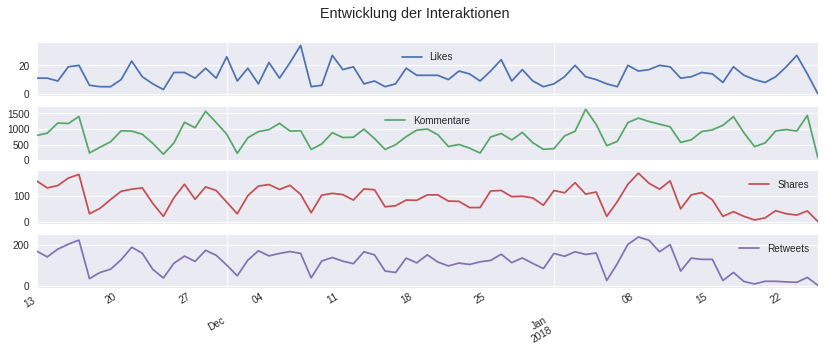

In [17]:
df.groupby(pd.TimeGrouper('d')).agg('sum').plot(subplots=True, figsize=(14,5), title='Entwicklung der Interaktionen')
plt.xlabel('')
plt.show()

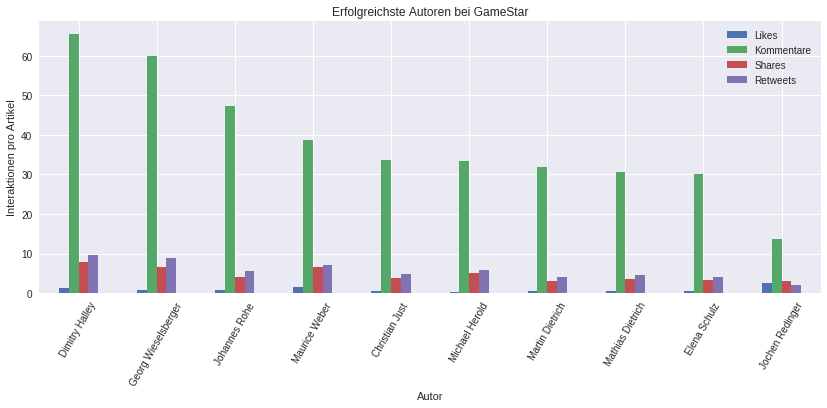

In [18]:
df_plot = df.groupby('Autor').agg({'Likes':'sum', 'Kommentare':'sum', 'Shares':'sum', 'Retweets':'sum', 'Title':'count'})

for column in ['Likes', 'Kommentare', 'Retweets', 'Shares']:
    df_plot[column] = df_plot[column]/df_plot['Title']

df_plot[df_plot['Title']>=10].head(10).drop('Title', axis=1).sort_values('Kommentare', ascending=False).plot(kind='bar', figsize=(14,5), title='Erfolgreichste Autoren bei GameStar')
plt.xticks(rotation=60)
plt.ylabel('Interaktionen pro Artikel')
plt.show()

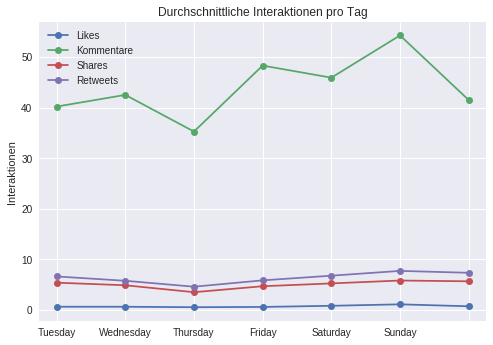

In [23]:
df_plot = df.groupby(df.index.weekday_name).mean().iloc[[1,5,6,4,0,2,3]]
df_plot.plot(marker='o', title='Durchschnittliche Interaktionen pro Tag')
plt.xlabel('')
plt.ylabel('Interaktionen')
plt.xlim([-0.25, 6.25])
plt.show()

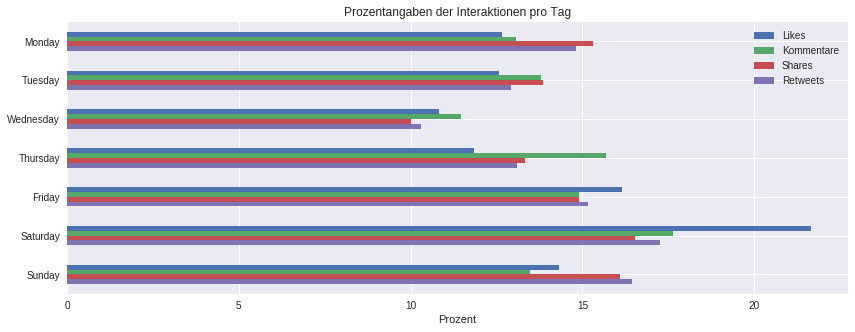

In [26]:
for column in df_plot.columns:
    df_plot[column] = df_plot[column] / df_plot[column].sum() *100
df_plot.plot(kind='barh', grid=True, figsize=(14,5), title='Prozentangaben der Interaktionen pro Tag')
plt.gca().invert_yaxis()
plt.xlabel('Prozent')
plt.ylabel('')
plt.show()

In [27]:
df_plot

,Likes,Kommentare,Shares,Retweets
Time,,,,
Monday,12.650102,13.055104,15.316460,14.819028
Tuesday,12.572015,13.804139,13.861869,12.915132
Wednesday,10.834755,11.452165,9.997253,10.309786
Thursday,11.850095,15.684674,13.325138,13.100652
Friday,16.138661,14.908128,14.901353,15.154637
Saturday,21.647709,17.619781,16.517395,17.266599
Sunday,14.306663,13.476010,16.080532,16.434165


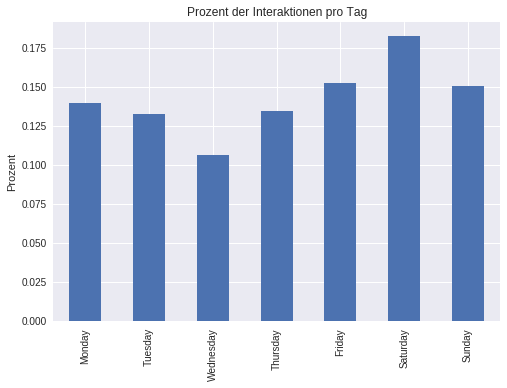

In [28]:
(df_plot.sum(axis=1)/df_plot.sum().sum()).plot(kind='bar', grid=True, title='Prozent der Interaktionen pro Tag')
plt.xlabel('')
plt.ylabel('Prozent')
plt.show()

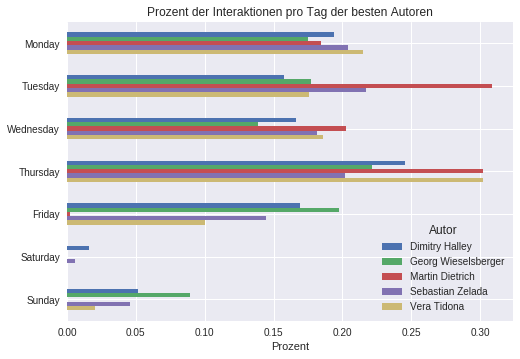

In [29]:
df_plot = df.groupby([df.index.weekday_name, 'Autor']).sum().reset_index().set_index('Time')
best_autors = df_plot.groupby('Autor').sum().sort_values('Kommentare', ascending=False).head().index
df_plot = df_plot[df_plot['Autor'].isin(best_autors)].reset_index().pivot(index='Time', columns='Autor', values='Kommentare').fillna(0).loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]
(df_plot / df_plot.sum()).plot(kind='barh', title='Prozent der Interaktionen pro Tag der besten Autoren')
plt.gca().invert_yaxis()
plt.xlabel('Prozent')
plt.ylabel('')
plt.show()

In [30]:
df_plot = df.groupby('Tag').agg({'Kommentare':'sum', 'Link':'count'})
df_plot['Ratio'] = df_plot['Kommentare'] / df_plot['Link']
df_plot = df_plot[df_plot['Link']>=5].sort_values('Ratio', ascending=False)
df_plot.head(2)

,Kommentare,Link,Ratio
Tag,,,
Star Citizen,2555,12,212.916667
Star Wars 8,1344,10,134.400000


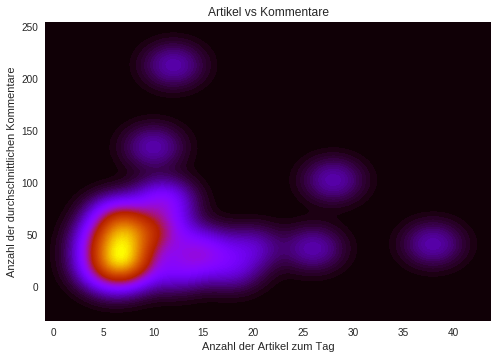

In [56]:
sns.kdeplot(df_plot['Link'].values, df_plot['Ratio'].values, n_levels=100, shade=True, cmap='gnuplot')
plt.title('Artikel vs Kommentare')
plt.xlabel('Anzahl der Artikel zum Tag')
plt.ylabel('Anzahl der durchschnittlichen Kommentare')
plt.show()

# Welche Themen ziehen Interaktion an?

In [164]:
from nltk.corpus import stopwords
stop_de = set(stopwords.words('german'))
stop_en = set(stopwords.words('english'))

word_dict = {}
for row in df.values:
    title = row[5] +' '+ row[6]
    for sign in ':.-,':
        title = title.replace(sign, ' ')
    words = [word.lower() for word in title.split(' ') if word and word.lower() not in stop_de and word.lower() not in stop_en and word not in '0123456789&']
    for word in words:
        if word in word_dict.keys():
            word_dict[word]['Likes'] += row[1]
            word_dict[word]['Kommentare'] += row[2]
            word_dict[word]['Shares'] += row[3]
            word_dict[word]['Retweets'] += row[4]
            word_dict[word]['Count'] += 1
        else:
            word_dict[word] = {}
            word_dict[word]['Likes'] = row[1]
            word_dict[word]['Kommentare'] = row[2]
            word_dict[word]['Shares'] = row[3]
            word_dict[word]['Retweets'] = row[4]
            word_dict[word]['Count'] = 1
df_word = pd.DataFrame(word_dict).T

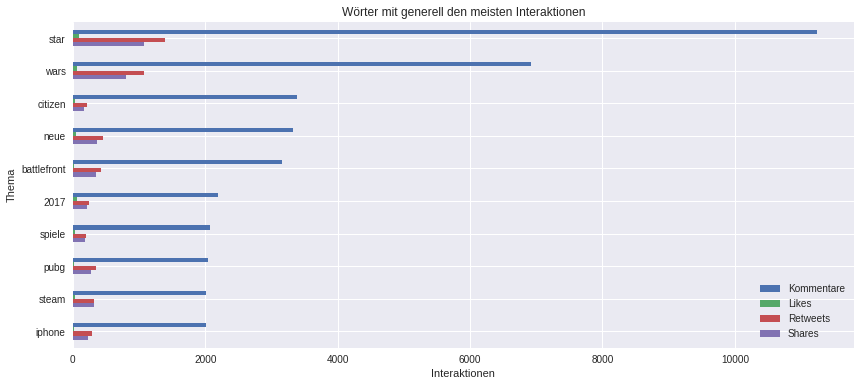

In [165]:
n = 10
df_word.drop('Count', axis=1).sort_values('Kommentare', ascending=False).head(n).plot(kind='barh', figsize=(14,6), title='Wörter mit generell den meisten Interaktionen')
plt.xlabel('Interaktionen')
plt.ylabel('Thema')
plt.gca().invert_yaxis()
plt.show()

In [166]:
df_word[['Kommentare', 'Likes', 'Retweets', 'Shares']] = df_word[['Kommentare', 'Likes', 'Retweets', 'Shares']].div(df_word['Count'], axis=0)

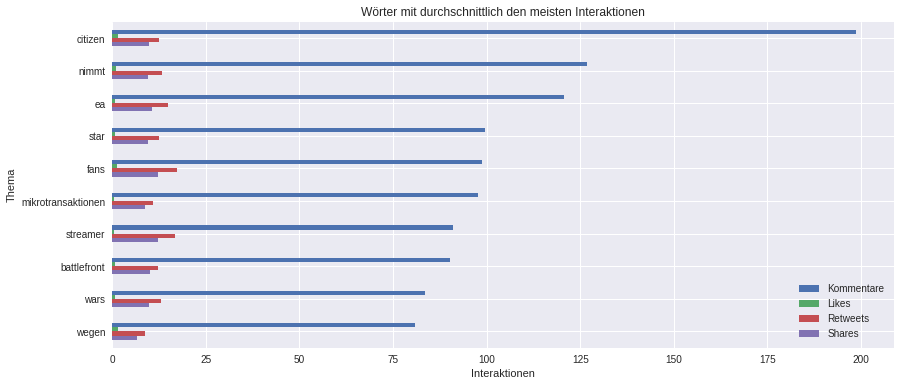

In [167]:
n = 10
df_word[df_word['Count']>=10].drop('Count', axis=1).sort_values('Kommentare', ascending=False).head(n).plot(kind='barh', figsize=(14,6), title='Wörter mit durchschnittlich den meisten Interaktionen')
plt.xlabel('Interaktionen')
plt.ylabel('Thema')
plt.gca().invert_yaxis()
plt.show()

# Wie sieht das Verhältnis der Interaktionen untereinander aus?

In [172]:
df_plot = df_word.sort_values('Kommentare', ascending=False)
df_plot[['Kommentare', 'Likes', 'Retweets', 'Shares']] = df_plot[['Kommentare', 'Likes', 'Retweets', 'Shares']].div(df_plot['Kommentare'], axis=0).div(df.sum() / df['Kommentare'].sum(), axis=1)

In [173]:
df_plot[df_plot['Count']>=10].sort_values('Likes', ascending=False).head()

,Count,Kommentare,Likes,Retweets,Shares
gamestar,15,1.0,9.262749,0.609230,0.854230
team,36,1.0,4.237162,3.083212,3.799996
warhammer,10,1.0,3.644360,1.740658,1.971299
adventure,12,1.0,3.340664,0.696263,0.700906
macher,18,1.0,3.001675,0.623656,0.730647


In [174]:
df_plot[df_plot['Count']>=10].sort_values('Retweets', ascending=False).head()

,Count,Kommentare,Likes,Retweets,Shares
ultimate,13,1.0,1.673093,3.771848,4.183136
team,36,1.0,4.237162,3.083212,3.799996
fifa,25,1.0,0.485594,2.875989,3.222042
woche,27,1.0,2.921273,2.381294,2.060071
map,22,1.0,1.375487,2.270505,1.904705


In [175]:
df_plot[df_plot['Count']>=10].sort_values('Shares', ascending=False).head()

,Count,Kommentare,Likes,Retweets,Shares
ultimate,13,1.0,1.673093,3.771848,4.183136
team,36,1.0,4.237162,3.083212,3.799996
fifa,25,1.0,0.485594,2.875989,3.222042
infos,10,1.0,1.170739,1.852007,2.769516
siege,11,1.0,1.095477,1.506912,2.449261


In [177]:
df.groupby('Autor').agg({'Title':'count'}).sort_values('Title', ascending=False).head()

,Title
Autor,
Martin Dietrich,165
Georg Wieselsberger,165
Sebastian Zelada,161
Vera Tidona,144
Christian Just,125


In [459]:
import numpy as np

def combine(x):
    return x.sort_index().tail(1).index[0].time()

df_plot = df[df['Autor']=='Georg Wieselsberger']['Autor'].to_frame()
df_plot = df_plot.groupby(df_plot.index.date).agg({'Autor':combine})
df_plot.index = pd.to_datetime(df_plot.index)

def meanTime(x):
    minutes = [time.minute + time.hour*60 for time in x]
    min_mean = np.mean(minutes)

    hour_mean = int(min_mean/60)
    minute_mean = int(min_mean%60)
    return '{}:{}:00'.format(hour_mean, minute_mean if minute_mean!=0 else '00')

def stdTime(x):
    minutes = [time.minute + time.hour*60 for time in x]
    min_std = np.std(minutes)

    hour_std = int(min_std/60)
    minute_std = int(min_std%60)
    return '{}:{}:00'.format(hour_std, minute_std if minute_std!=0 else '00')
        
df_plot = df_plot.groupby(df_plot.index.weekday_name).agg({'Autor':[meanTime, stdTime, 'count']}).iloc[[1,3,4,2,0]]
df_plot.columns = df_plot.columns.droplevel()
for column in ['meanTime', 'stdTime']:
    df_plot[column] = pd.to_datetime(df_plot[column]).dt.time
df_plot

,meanTime,stdTime,count
Monday,11:42:00,01:59:00,10
Thursday,11:40:00,01:54:00,8
Tuesday,10:55:00,01:43:00,11
Sunday,10:56:00,00:41:00,10
Friday,11:50:00,02:00:00,10


In [471]:
import numpy as np

def combine(x):
    return x.sort_index().tail(1).index[0].time()

df_plot = df[df['Autor'].isin(['Georg Wieselsberger', 'Martin Dietrich'])]['Autor'].to_frame()
df_plot = df_plot.groupby([df_plot.index.date, 'Autor']).agg({'Autor':combine}).rename(columns={'Autor':'Dauer'}).reset_index().rename(columns={'level_0':'Date'}).set_index('Date')
df_plot.index = pd.to_datetime(df_plot.index)

def meanTime(x):
    minutes = [time.minute + time.hour*60 for time in x]
    min_mean = np.mean(minutes)

    hour_mean = int(min_mean/60)
    minute_mean = int(min_mean%60)
    return '{}:{}:00'.format(hour_mean, minute_mean if minute_mean!=0 else '00')

def stdTime(x):
    minutes = [time.minute + time.hour*60 for time in x]
    min_std = np.std(minutes)

    hour_std = int(min_std/60)
    minute_std = int(min_std%60)
    return '{}:{}:00'.format(hour_std, minute_std if minute_std!=0 else '00')

df_plot = df_plot.groupby([df_plot.index.weekday_name, 'Autor']).agg({'Dauer':[meanTime, stdTime, 'count']}).reset_index().set_index('Date').loc[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']].dropna()
df_plot.columns = df_plot.columns.droplevel()
df_plot = df_plot.rename(columns={'':'Autor'})
for column in ['meanTime', 'stdTime']:
    df_plot[column] = pd.to_datetime(df_plot[column]).dt.time
df_plot.head(2)

,Autor,meanTime,stdTime,count
Date,,,,
Monday,Georg Wieselsberger,11:42:00,01:59:00,10.0
Monday,Martin Dietrich,17:00:00,02:12:00,10.0
